Load pre-trained model. Training dataset was 23M sequences from PubChem + SureChEMBL + SmProt + RandPept.

More details and training scripts:
- https://www.biorxiv.org/content/10.1101/2024.08.09.607221v1
- https://github.com/AaronFeller/PeptideCLM/

In [1]:
import pandas as pd

path = "https://github.com/lbugnon/foundation_models_bioinfo/raw/refs/heads/main/data/"
smiles = pd.read_csv(f"{path}smiles_pampa.csv")
smiles.shape

(5333, 3)

<Axes: >

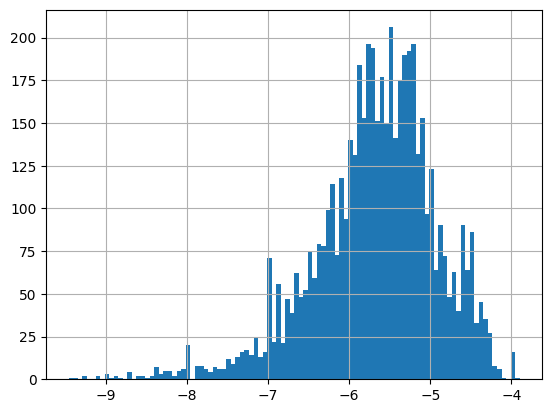

In [2]:
smiles.PAMPA.hist(bins=100);

## Installation
SMILES ad-hoc tokenizer

In [3]:
!pip install SmilesPE datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 12.1 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [4]:
import collections
import logging
import os
import re
import codecs
import unicodedata
from typing import List, Optional
from transformers import PreTrainedTokenizer

def load_vocab(vocab_file):
    """Loads a vocabulary file into a dictionary."""
    vocab = collections.OrderedDict()
    with open(vocab_file, "r", encoding="utf-8") as reader:
        tokens = reader.readlines()
    for index, token in enumerate(tokens):
        token = token.rstrip("\n")
        vocab[token] = index
    return vocab

class Atomwise_Tokenizer(object):
    """Run atom-level SMILES tokenization"""

    def __init__(self):
        """ Constructs a atom-level Tokenizer.
        """
        # self.regex_pattern = r"(\[[^\]]+]|Br?|Cl?|N|O|S|P|F|I|b|c|n|o|s|p|\(|\)|\.|=|#|-|\+|\\|\/|:|~|@|\?|>>?|\*|\$|\%[0-9]{2}|[0-9])"
        self.regex_pattern = r"(\([^\(\)]{0,4}\)|\[[^\]]+]|Br?|Cl?|N|O|S|P|F|I|b|c|n|o|s|p|\(|\)|\.|=|#|-|\+|\\|\/\/?|:|~|@|\?|>>?|\*|\$|\%[0-9]{2}|[0-9])"

        self.regex = re.compile(self.regex_pattern)

    def tokenize(self, text):
        """ Basic Tokenization of a SMILES.
        """
        tokens = [token for token in self.regex.findall(text)]
        return tokens

class SMILES_SPE_Tokenizer(PreTrainedTokenizer):
    r"""
    Constructs a SMILES tokenizer. Based on SMILES Pair Encoding (https://github.com/XinhaoLi74/SmilesPE).
    This tokenizer inherits from :class:`~transformers.PreTrainedTokenizer` which contains most of the methods. Users
    should refer to the superclass for more information regarding methods.
    Args:
        vocab_file (:obj:`string`):
            File containing the vocabulary.
        spe_file (:obj:`string`):
            File containing the trained SMILES Pair Encoding vocabulary.
        unk_token (:obj:`string`, `optional`, defaults to "[UNK]"):
            The unknown token. A token that is not in the vocabulary cannot be converted to an ID and is set to be this
            token instead.
        sep_token (:obj:`string`, `optional`, defaults to "[SEP]"):
            The separator token, which is used when building a sequence from multiple sequences, e.g. two sequences
            for sequence classification or for a text and a question for question answering.
            It is also used as the last token of a sequence built with special tokens.
        pad_token (:obj:`string`, `optional`, defaults to "[PAD]"):
            The token used for padding, for example when batching sequences of different lengths.
        cls_token (:obj:`string`, `optional`, defaults to "[CLS]"):
            The classifier token which is used when doing sequence classification (classification of the whole
            sequence instead of per-token classification). It is the first token of the sequence when built with
            special tokens.
        mask_token (:obj:`string`, `optional`, defaults to "[MASK]"):
            The token used for masking values. This is the token used when training this model with masked language
            modeling. This is the token which the model will try to predict.
    """

    def __init__(self, vocab_file, spe_file,
                unk_token="[UNK]",
                sep_token="[SEP]",
                pad_token="[PAD]",
                cls_token="[CLS]",
                mask_token="[MASK]",
                **kwargs):
        if not os.path.isfile(vocab_file):
            raise ValueError("Can't find a vocabulary file at path '{}'.".format(vocab_file))
        if not os.path.isfile(spe_file):
            raise ValueError("Can't find a SPE vocabulary file at path '{}'.".format(spe_file))

        self.vocab = load_vocab(vocab_file)
        self.spe_vocab = open(spe_file, 'r', encoding='utf-8')
        self.ids_to_tokens = collections.OrderedDict([(ids, tok) for tok, ids in self.vocab.items()])
        self.spe_tokenizer = SPE_Tokenizer(self.spe_vocab)

        super().__init__(
            unk_token=unk_token,
            sep_token=sep_token,
            pad_token=pad_token,
            cls_token=cls_token,
            mask_token=mask_token,
            **kwargs)

    @property
    def vocab_size(self):
        return len(self.vocab)

    def get_vocab(self):
        return dict(self.vocab, **self.added_tokens_encoder)

    def _tokenize(self, text):
        return self.spe_tokenizer.tokenize(text).split(' ')

    def _convert_token_to_id(self, token):
        """ Converts a token (str) in an id using the vocab. """
        return self.vocab.get(token, self.vocab.get(self.unk_token))

    def decode(self, token_ids, skip_special_tokens=False, clean_up_tokenization_spaces=True):
        text = self.convert_ids_to_tokens(token_ids, skip_special_tokens=skip_special_tokens)
        return self.convert_tokens_to_string(text)

    def _convert_id_to_token(self, index):
        """Converts an index (integer) in a token (str) using the vocab."""
        return self.ids_to_tokens.get(index, self.unk_token)

    def convert_tokens_to_string(self, tokens):
        """ Converts a sequence of tokens (string) in a single string. """
        out_string = " ".join(tokens).replace(" ##", "").strip()
        return out_string

    def build_inputs_with_special_tokens(
        self, token_ids_0: List[int], token_ids_1: Optional[List[int]] = None
    ) -> List[int]:
        """
        Build model inputs from a sequence or a pair of sequence for sequence classification tasks
        by concatenating and adding special tokens.
        A BERT sequence has the following format:
        - single sequence: ``[CLS] X [SEP]``
        - pair of sequences: ``[CLS] A [SEP] B [SEP]``
        Args:
            token_ids_0 (:obj:`List[int]`):
                List of IDs to which the special tokens will be added
            token_ids_1 (:obj:`List[int]`, `optional`, defaults to :obj:`None`):
                Optional second list of IDs for sequence pairs.
        Returns:
            :obj:`List[int]`: list of `input IDs <../glossary.html#input-ids>`__ with the appropriate special tokens.
        """
        if token_ids_1 is None:
            return [self.cls_token_id] + token_ids_0 + [self.sep_token_id]
        cls = [self.cls_token_id]
        sep = [self.sep_token_id]
        return cls + token_ids_0 + sep + token_ids_1 + sep

    def get_special_tokens_mask(
        self, token_ids_0: List[int], token_ids_1: Optional[List[int]] = None, already_has_special_tokens: bool = False
    ) -> List[int]:
        """
        Retrieves sequence ids from a token list that has no special tokens added. This method is called when adding
        special tokens using the tokenizer ``prepare_for_model`` method.
        Args:
            token_ids_0 (:obj:`List[int]`):
                List of ids.
            token_ids_1 (:obj:`List[int]`, `optional`, defaults to :obj:`None`):
                Optional second list of IDs for sequence pairs.
            already_has_special_tokens (:obj:`bool`, `optional`, defaults to :obj:`False`):
                Set to True if the token list is already formatted with special tokens for the model
        Returns:
            :obj:`List[int]`: A list of integers in the range [0, 1]: 1 for a special token, 0 for a sequence token.
        """

        if already_has_special_tokens:
            if token_ids_1 is not None:
                raise ValueError(
                    "You should not supply a second sequence if the provided sequence of "
                    "ids is already formated with special tokens for the model."
                )
            return list(map(lambda x: 1 if x in [self.sep_token_id, self.cls_token_id] else 0, token_ids_0))

        if token_ids_1 is not None:
            return [1] + ([0] * len(token_ids_0)) + [1] + ([0] * len(token_ids_1)) + [1]
        return [1] + ([0] * len(token_ids_0)) + [1]

    def create_token_type_ids_from_sequences(
        self, token_ids_0: List[int], token_ids_1: Optional[List[int]] = None
    ) -> List[int]:
        """
        Creates a mask from the two sequences passed to be used in a sequence-pair classification task.
        A BERT sequence pair mask has the following format:
        ::
            0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1
            | first sequence    | second sequence |
        if token_ids_1 is None, only returns the first portion of the mask (0's).
        Args:
            token_ids_0 (:obj:`List[int]`):
                List of ids.
            token_ids_1 (:obj:`List[int]`, `optional`, defaults to :obj:`None`):
                Optional second list of IDs for sequence pairs.
        Returns:
            :obj:`List[int]`: List of `token type IDs <../glossary.html#token-type-ids>`_ according to the given
            sequence(s).
        """
        sep = [self.sep_token_id]
        cls = [self.cls_token_id]
        if token_ids_1 is None:
            return len(cls + token_ids_0 + sep) * [0]
        return len(cls + token_ids_0 + sep) * [0] + len(token_ids_1 + sep) * [1]

    def save_vocabulary(self, vocab_path):
        """
        Save the sentencepiece vocabulary (copy original file) and special tokens file to a directory.
        Args:
            vocab_path (:obj:`str`):
                The directory in which to save the vocabulary.
        Returns:
            :obj:`Tuple(str)`: Paths to the files saved.
        """
        index = 0
        if os.path.isdir(vocab_path):
            vocab_file = os.path.join(vocab_path, VOCAB_FILES_NAMES["vocab_file"])
        else:
            vocab_file = vocab_path
        with open(vocab_file, "w", encoding="utf-8") as writer:
            for token, token_index in sorted(self.vocab.items(), key=lambda kv: kv[1]):
                if index != token_index:
                    logger.warning(
                        "Saving vocabulary to {}: vocabulary indices are not consecutive."
                        " Please check that the vocabulary is not corrupted!".format(vocab_file)
                    )
                    index = token_index
                writer.write(token + "\n")
                index += 1
        return (vocab_file,)

class SMILES_Atomwise_Tokenizer(PreTrainedTokenizer):
    r"""
    Constructs a SMILES tokenizer. Based on SMILES Pair Encoding (https://github.com/XinhaoLi74/SmilesPE).
    This tokenizer inherits from :class:`~transformers.PreTrainedTokenizer` which contains most of the methods. Users
    should refer to the superclass for more information regarding methods.
    Args:
        vocab_file (:obj:`string`):
            File containing the vocabulary.
        unk_token (:obj:`string`, `optional`, defaults to "[UNK]"):
            The unknown token. A token that is not in the vocabulary cannot be converted to an ID and is set to be this
            token instead.
        sep_token (:obj:`string`, `optional`, defaults to "[SEP]"):
            The separator token, which is used when building a sequence from multiple sequences, e.g. two sequences
            for sequence classification or for a text and a question for question answering.
            It is also used as the last token of a sequence built with special tokens.
        pad_token (:obj:`string`, `optional`, defaults to "[PAD]"):
            The token used for padding, for example when batching sequences of different lengths.
        cls_token (:obj:`string`, `optional`, defaults to "[CLS]"):
            The classifier token which is used when doing sequence classification (classification of the whole
            sequence instead of per-token classification). It is the first token of the sequence when built with
            special tokens.
        mask_token (:obj:`string`, `optional`, defaults to "[MASK]"):
            The token used for masking values. This is the token used when training this model with masked language
            modeling. This is the token which the model will try to predict.
    """

    def __init__(
        self,
        vocab_file,
        unk_token="[UNK]",
        sep_token="[SEP]",
        pad_token="[PAD]",
        cls_token="[CLS]",
        mask_token="[MASK]",
        **kwargs
    ):
        super().__init__(
            unk_token=unk_token,
            sep_token=sep_token,
            pad_token=pad_token,
            cls_token=cls_token,
            mask_token=mask_token,
            **kwargs,
        )

        if not os.path.isfile(vocab_file):
            raise ValueError(
                "Can't find a vocabulary file at path '{}'.".format(vocab_file)
            )
        self.vocab = load_vocab(vocab_file)
        self.ids_to_tokens = collections.OrderedDict([(ids, tok) for tok, ids in self.vocab.items()])
        self.tokenizer = Atomwise_Tokenizer()

    @property
    def vocab_size(self):
        return len(self.vocab)

    def get_vocab(self):
        return dict(self.vocab, **self.added_tokens_encoder)

    def _tokenize(self, text):
        return self.tokenizer.tokenize(text)

    def _convert_token_to_id(self, token):
        """ Converts a token (str) in an id using the vocab. """
        return self.vocab.get(token, self.vocab.get(self.unk_token))

    def _convert_id_to_token(self, index):
        """Converts an index (integer) in a token (str) using the vocab."""
        return self.ids_to_tokens.get(index, self.unk_token)

    def convert_tokens_to_string(self, tokens):
        """ Converts a sequence of tokens (string) in a single string. """
        out_string = " ".join(tokens).replace(" ##", "").strip()
        return out_string

    def build_inputs_with_special_tokens(
        self, token_ids_0: List[int], token_ids_1: Optional[List[int]] = None
    ) -> List[int]:
        """
        Build model inputs from a sequence or a pair of sequence for sequence classification tasks
        by concatenating and adding special tokens.
        A BERT sequence has the following format:
        - single sequence: ``[CLS] X [SEP]``
        - pair of sequences: ``[CLS] A [SEP] B [SEP]``
        Args:
            token_ids_0 (:obj:`List[int]`):
                List of IDs to which the special tokens will be added
            token_ids_1 (:obj:`List[int]`, `optional`, defaults to :obj:`None`):
                Optional second list of IDs for sequence pairs.
        Returns:
            :obj:`List[int]`: list of `input IDs <../glossary.html#input-ids>`__ with the appropriate special tokens.
        """
        if token_ids_1 is None:
            return [self.cls_token_id] + token_ids_0 + [self.sep_token_id]
        cls = [self.cls_token_id]
        sep = [self.sep_token_id]
        return cls + token_ids_0 + sep + token_ids_1 + sep

    def get_special_tokens_mask(
        self, token_ids_0: List[int], token_ids_1: Optional[List[int]] = None, already_has_special_tokens: bool = False
    ) -> List[int]:
        """
        Retrieves sequence ids from a token list that has no special tokens added. This method is called when adding
        special tokens using the tokenizer ``prepare_for_model`` method.
        Args:
            token_ids_0 (:obj:`List[int]`):
                List of ids.
            token_ids_1 (:obj:`List[int]`, `optional`, defaults to :obj:`None`):
                Optional second list of IDs for sequence pairs.
            already_has_special_tokens (:obj:`bool`, `optional`, defaults to :obj:`False`):
                Set to True if the token list is already formatted with special tokens for the model
        Returns:
            :obj:`List[int]`: A list of integers in the range [0, 1]: 1 for a special token, 0 for a sequence token.
        """

        if already_has_special_tokens:
            if token_ids_1 is not None:
                raise ValueError(
                    "You should not supply a second sequence if the provided sequence of "
                    "ids is already formated with special tokens for the model."
                )
            return list(map(lambda x: 1 if x in [self.sep_token_id, self.cls_token_id] else 0, token_ids_0))

        if token_ids_1 is not None:
            return [1] + ([0] * len(token_ids_0)) + [1] + ([0] * len(token_ids_1)) + [1]
        return [1] + ([0] * len(token_ids_0)) + [1]

    def create_token_type_ids_from_sequences(
        self, token_ids_0: List[int], token_ids_1: Optional[List[int]] = None
    ) -> List[int]:
        """
        Creates a mask from the two sequences passed to be used in a sequence-pair classification task.
        A BERT sequence pair mask has the following format:
        ::
            0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1
            | first sequence    | second sequence |
        if token_ids_1 is None, only returns the first portion of the mask (0's).
        Args:
            token_ids_0 (:obj:`List[int]`):
                List of ids.
            token_ids_1 (:obj:`List[int]`, `optional`, defaults to :obj:`None`):
                Optional second list of IDs for sequence pairs.
        Returns:
            :obj:`List[int]`: List of `token type IDs <../glossary.html#token-type-ids>`_ according to the given
            sequence(s).
        """
        sep = [self.sep_token_id]
        cls = [self.cls_token_id]
        if token_ids_1 is None:
            return len(cls + token_ids_0 + sep) * [0]
        return len(cls + token_ids_0 + sep) * [0] + len(token_ids_1 + sep) * [1]

    def save_vocabulary(self, vocab_path):
        """
        Save the sentencepiece vocabulary (copy original file) and special tokens file to a directory.
        Args:
            vocab_path (:obj:`str`):
                The directory in which to save the vocabulary.
        Returns:
            :obj:`Tuple(str)`: Paths to the files saved.
        """
        index = 0
        if os.path.isdir(vocab_path):
            vocab_file = os.path.join(vocab_path, VOCAB_FILES_NAMES["vocab_file"])
        else:
            vocab_file = vocab_path
        with open(vocab_file, "w", encoding="utf-8") as writer:
            for token, token_index in sorted(self.vocab.items(), key=lambda kv: kv[1]):
                if index != token_index:
                    logger.warning(
                        "Saving vocabulary to {}: vocabulary indices are not consecutive."
                        " Please check that the vocabulary is not corrupted!".format(vocab_file)
                    )
                    index = token_index
                writer.write(token + "\n")
                index += 1
        return (vocab_file,)

## Model definition

In [5]:
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from SmilesPE.tokenizer import SPE_Tokenizer

model_name = 'aaronfeller/PeptideCLM-23.4M-all'
!gdown 1vEyJt-8RHHY48QsEf_7UFfP30kkkBwbi # tokenizer files
!gdown 1qtCAUPOhfdF4TsCblBoGn-tKiO15s1Po

tokenizer = SMILES_SPE_Tokenizer('new_vocab.txt', 'new_splits.txt')
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=1)
model

Downloading...
From: https://drive.google.com/uc?id=1vEyJt-8RHHY48QsEf_7UFfP30kkkBwbi
To: /content/new_vocab.txt
100% 2.99k/2.99k [00:00<00:00, 8.97MB/s]
Downloading...
From: https://drive.google.com/uc?id=1qtCAUPOhfdF4TsCblBoGn-tKiO15s1Po
To: /content/new_splits.txt
100% 716/716 [00:00<00:00, 1.99MB/s]


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/573 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/175M [00:00<?, ?B/s]

Some weights of RoFormerForSequenceClassification were not initialized from the model checkpoint at aaronfeller/PeptideCLM-23.4M-all and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RoFormerForSequenceClassification(
  (roformer): RoFormerModel(
    (embeddings): RoFormerEmbeddings(
      (word_embeddings): Embedding(586, 768, padding_idx=0)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RoFormerEncoder(
      (embed_positions): RoFormerSinusoidalPositionalEmbedding(768, 64)
      (layer): ModuleList(
        (0-5): 6 x RoFormerLayer(
          (attention): RoFormerAttention(
            (self): RoFormerSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RoFormerSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)


In [6]:
input = tokenizer.encode(smiles.iloc[0].SMILES, return_tensors="pt")
smiles.iloc[0].SMILES

'CC[C@H](C)[C@@H]1NC(=O)[C@@H]2CCCN2C(=O)[C@@H](CC(C)C)OC(=O)CCNC(=O)[C@H](C)N(C)C(=O)[C@H](C(C)C)NC1=O'

In [7]:
input

tensor([[  2,  29, 487, 193,   8, 485,  13,  58, 207, 485,  14,  30,  58,  14,
         207, 485, 193,  28, 193,   8, 194,  66, 207,  31, 207, 487, 193,   8,
          58, 193,   8, 207, 487, 193, 193,   8, 194,  59,  13, 174,   3]])

In [8]:
print(tokenizer.get_vocab())

{'[PAD]': 0, '[UNK]': 1, '[CLS]': 2, '[SEP]': 3, '[MASK]': 4, '#': 5, '%': 6, '(': 7, ')': 8, '+': 9, '-': 10, '/': 11, '0': 12, '1': 13, '2': 14, '3': 15, '4': 16, '5': 17, '6': 18, '7': 19, '8': 20, '9': 21, '=': 22, '@': 23, 'A': 24, 'B': 25, 'Br': 26, 'Brc': 27, 'C': 28, 'CC': 29, 'CCC': 30, 'CCN': 31, 'CCO': 32, 'CCS': 33, 'CCc': 34, 'CCn': 35, 'CN': 36, 'CNC': 37, 'CNc': 38, 'CO': 39, 'COC': 40, 'CON': 41, 'COc': 42, 'CS': 43, 'CSC': 44, 'CSS': 45, 'CSc': 46, 'Cc': 47, 'Cl': 48, 'Clc': 49, 'Cn': 50, 'F': 51, 'Fc': 52, 'H': 53, 'I': 54, 'K': 55, 'L': 56, 'M': 57, 'N': 58, 'NC': 59, 'NCC': 60, 'NCc': 61, 'NN': 62, 'NO': 63, 'Nc': 64, 'Nn': 65, 'O': 66, 'OC': 67, 'OCC': 68, 'OCO': 69, 'OCc': 70, 'ON': 71, 'OO': 72, 'Oc': 73, 'P': 74, 'R': 75, 'S': 76, 'SC': 77, 'SCC': 78, 'SCc': 79, 'SS': 80, 'Sc': 81, 'T': 82, 'X': 83, 'Z': 84, '[': 85, '\\\\': 86, '(/': 87, ']': 88, 'a': 89, 'b': 90, 'c': 91, 'cc': 92, 'ccc': 93, 'ccn': 94, 'cco': 95, 'ccs': 96, 'cn': 97, 'cnc': 98, 'cnn': 99, 'co